In [1]:
!pip install langchain langgraph langchain-openai langchain-text-splitters langchain-community networkx matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 23.3 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.77
    Uninstalling langchain-core-0.

In [2]:
import os

os.environ["OPENAI_API_KEY"] = "API_KEY_HERE"


In [15]:
from typing_extensions import TypedDict, List

class State(TypedDict):
    question: str
    answer: str
    history: List[str]  # Stores all previous Q&A


In [16]:
from langchain.chat_models import init_chat_model

llm = init_chat_model("openai:gpt-4.1", temperature=0.3)


In [25]:
# Classify (optional, can be used for routing)
def classify(state: State):
    return {"question": state["question"]}

# Generate answer using memory
def generate(state: State):
    # Combine history into context
    history_context = "\n".join(state.get("history", []))
    prompt = f"""
You are a conversational AI assistant. Use the conversation history to answer naturally.

Conversation History:
{history_context}

New Question:
{state['question']}

Answer:"""
    response = llm.invoke([{"role": "user", "content": prompt}])
    return {"answer": response.content}

# Refine answer and store in history
def refine(state: State):
    refined = state["answer"]
    # Append current Q&A to history
    history = state.get("history", [])
    history.append(f"Q: {state['question']}\nA: {refined}")
    return {"answer": refined, "history": history}


In [26]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([classify, generate, refine])
graph_builder.add_edge(START, "classify")
graph = graph_builder.compile()


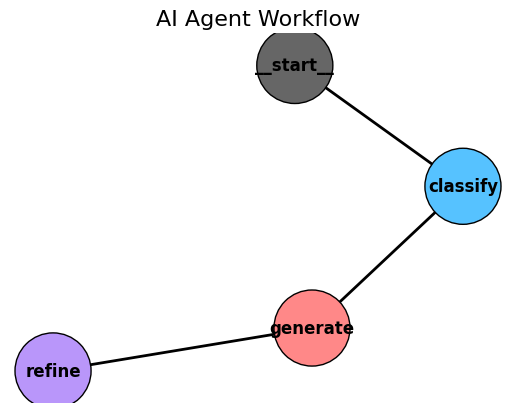

In [29]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_langgraph(graph_builder):
    G = nx.DiGraph()
    for node in graph_builder.nodes:
        G.add_node(node)
    for src, tgt in graph_builder.edges:
        G.add_edge(src, tgt)

    pos = nx.spring_layout(G, seed=42, k=1.2)
    colors = ["#56c2ff", "#ff8888", "#b996fa", "#666666"]
    sizes = [3000] * len(G.nodes)

    nx.draw_networkx_nodes(G, pos, node_color=colors[:len(G.nodes)], node_size=sizes, edgecolors='black')
    nx.draw_networkx_edges(G, pos, arrows=True, width=2)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    plt.title("AI Agent Workflow", fontsize=16)
    plt.axis('off')
    plt.show()

visualize_langgraph(graph_builder)


In [28]:
state = {"question": "", "answer": "", "history": []}

print("AI Agent with memory ready! Type 'exit' to quit.")

while True:
    question = input("Enter your question: ")
    if question.lower() in ("exit", "quit"):
        break
    state["question"] = question
    response = graph.invoke(state)
    state.update(response)  # Update memory with latest answer
    print("\nAnswer:\n", response.get("answer", "No answer generated."))
    print("\n" + "="*60 + "\n")


AI Agent with memory ready! Type 'exit' to quit.
Enter your question: What is 12x12

Answer:
 12 x 12 is 144.


Enter your question: What are the first 15 prime numbers

Answer:
 The first 15 prime numbers are:  
2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, and 47.


Enter your question: What are first 10 Fibonacci numbers

Answer:
 The first 10 Fibonacci numbers are:  
0, 1, 1, 2, 3, 5, 8, 13, 21, and 34.


Enter your question: Add these fibonnaci numbers and give sum

Answer:
 Sure! Let's add the first 10 Fibonacci numbers:

0 + 1 + 1 + 2 + 3 + 5 + 8 + 13 + 21 + 34 = **88**

So, the sum is **88**.


Enter your question: exit
